## View the connectivity matrices in R to check for Liz to move on to more particles, longer releases

In [3]:
Packages <- c("dplyr","lattice", "ggplot2", "dplyr","ncdf4", "tidyr", "stringr", "tidyverse", "raster", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')

source("~/scripts/conleyte.R")
source("~/scripts/conlabor.R")
labor <- conlabor()
leyte <- conleyte()


In [4]:
#conn_mat <- raster("~/oceanography/ROMS/data/Camotes_Sea_Connectivity_Matrices_08_day_PLD.nc", values=T, band=1)
conn_mat_all <- brick("~/oceanography/ROMS/data/Camotes_Sea_Connectivity_Matrices_08_day_PLD.nc", values=T) 

    

In [101]:
head(source_id)

sources,source_ind
palanas,1
wangag,2
magbangon,3
cabatoan,4
caridad_cem,5
caridad_prop,6


In [144]:
sites <- as.character(c("Palanas", "Wangag", "Magbangon", "Cabatoan", "Caridad_Cem", "Caridad_Prop", "Hicgop", "Hicgop_South", "Sitio_Tugas", "El_School", "Sitio_Lonas", "San_Agustin", "Poroc_San_Flower", "Poroc_Rose", "Pangasugan", "Visca", "Gabas", "Tamakin_Dacot", "Haina", "Sitio_Baybayon", "sandflat1", "sandflat2", "sandflat3", "sandflat4", "sandflat5", "sandflat6", "Camotes_islands", "Other"))
site_ind <- c(seq(1,28, 1))
site_id <- as.data.frame(cbind(sites, site_ind), stringsAsFactors = F)
site_id$site_ind <- as.numeric(site_id$site_ind)



In [145]:
col <- "date"
col2 <- "index"
season1 <- as.data.frame(seq(as.Date("2010/10/01"), as.Date("2011/05/31"), by="days"))
names(season1) <- col

season2 <- as.data.frame(seq(as.Date("2011/10/01"), as.Date("2012/05/31"), by="days"))
names(season2) <- col

season3 <- as.data.frame(seq(as.Date("2012/10/01"), as.Date("2013/05/31"), by="days"))
names(season3) <- col

season4 <- as.data.frame(seq(as.Date("2013/10/01"), as.Date("2014/04/18"), by="days"))
names(season4) <- col

all_dates <- bind_rows(season1, season2, season3, season4)
time_step <- as.data.frame(seq(1,930,1))
names(time_step)<- col2
all_dates2 <- bind_cols(time_step, all_dates)
dim(all_dates2)


[1] 930   2

In [146]:
#make each daily connectivity matrix into a df and then pull them all together into a list
#conn_mat_list <- vector("list", nrow(all_dates2))

#date_df <- do.call("rbind", replicate(784, date, simplify = FALSE))

conn_mat_full <- as.data.frame(matrix(nrow=0, ncol=4))

cols_conn_mat <- c("date","source", "sink", "fraction")
cols_tmp <- c("source", "sink", "fraction")

names(conn_mat_full) <- cols_conn_mat

for(i in 1:nrow(all_dates2)){
    
    index_eval <- all_dates2$index[i]
    
    tmp <- as.data.frame(conn_mat_all[[i]], xy=T)   #pull out a data frame for each date
    names(tmp) <- cols_tmp
    
    date <- filter(all_dates2, index==index_eval)[2] #grab the date
    date_df <- do.call("rbind", replicate(784, date, simplify = FALSE)) #make a df of the date
    tmp2 <- bind_cols(date_df, tmp)

 
    conn_mat_full <- bind_rows(conn_mat_full, tmp2) 
}



In [147]:
#connect site names
conn_mat_full2 <- left_join(conn_mat_full, site_id, by=c(source="site_ind")) %>%
    dplyr::select(-source) %>%
    rename(source="sites")
    
conn_mat_full3 <- left_join(conn_mat_full2, site_id, by=c(sink="site_ind")) %>%
    dplyr::select(-sink) %>%
    rename(destination="sites")

    

In [148]:
#make into factors for plotting
conn_mat_full3$source <-factor(conn_mat_full3$source, levels=c("Palanas", "Wangag", "Magbangon", "Cabatoan", "Caridad_Cem", "Caridad_Prop", "Hicgop", "Hicgop_South", "Sitio_Tugas", "El_School", "Sitio_Lonas", "San_Agustin", "Poroc_San_Flower", "Poroc_Rose", "Pangasugan", "Visca", "Gabas", "Tamakin_Dacot", "Haina", "Sitio_Baybayon", "sandflat1", "sandflat2", "sandflat3", "sandflat4", "sandflat5", "sandflat6", "Camotes_islands", "Other"))
conn_mat_full3$destination <-factor(conn_mat_full3$destination, levels=c("Palanas", "Wangag", "Magbangon", "Cabatoan", "Caridad_Cem", "Caridad_Prop", "Hicgop", "Hicgop_South", "Sitio_Tugas", "El_School", "Sitio_Lonas", "San_Agustin", "Poroc_San_Flower", "Poroc_Rose", "Pangasugan", "Visca", "Gabas", "Tamakin_Dacot", "Haina", "Sitio_Baybayon", "sandflat1", "sandflat2", "sandflat3", "sandflat4", "sandflat5", "sandflat6", "Camotes_islands", "Other"))



In [149]:
#make an average df
avg <- conn_mat_full3 %>%
    group_by(source, destination) %>%
    summarise(avg=mean(fraction))


In [150]:
#just each year's avg
avg12 <- conn_mat_full3 %>%
    filter(date >= "2012-01-01" & date <= "2012-12-31") %>%
    group_by(source, destination) %>%
    summarise(avg=mean(fraction))

avg13 <- conn_mat_full3 %>%
    filter(date >= "2013-01-01" & date <= "2013-12-31") %>%
    group_by(source, destination) %>%
    summarise(avg=mean(fraction))

avg14 <- conn_mat_full3 %>%
    filter(date >= "2014-01-01" & date <= "2014-12-31") %>%
    group_by(source, destination) %>%
    summarise(avg=mean(fraction))

In [151]:
# try monthly
spring12 <- conn_mat_full3 %>%
    filter(date >= "2012-04-01" & date <= "2012-05-31") %>%
    group_by(source, destination) %>%
    summarise(max=max(fraction))

spring13 <- conn_mat_full3 %>%
    filter(date >= "2013-04-01" & date <= "2013-05-31") %>%
    group_by(source, destination) %>%
    summarise(max=max(fraction))

spring14 <- conn_mat_full3 %>%
    filter(date >= "2014-04-01" & date <= "2014-05-31") %>%
    group_by(source, destination) %>%
    summarise(max=max(fraction))

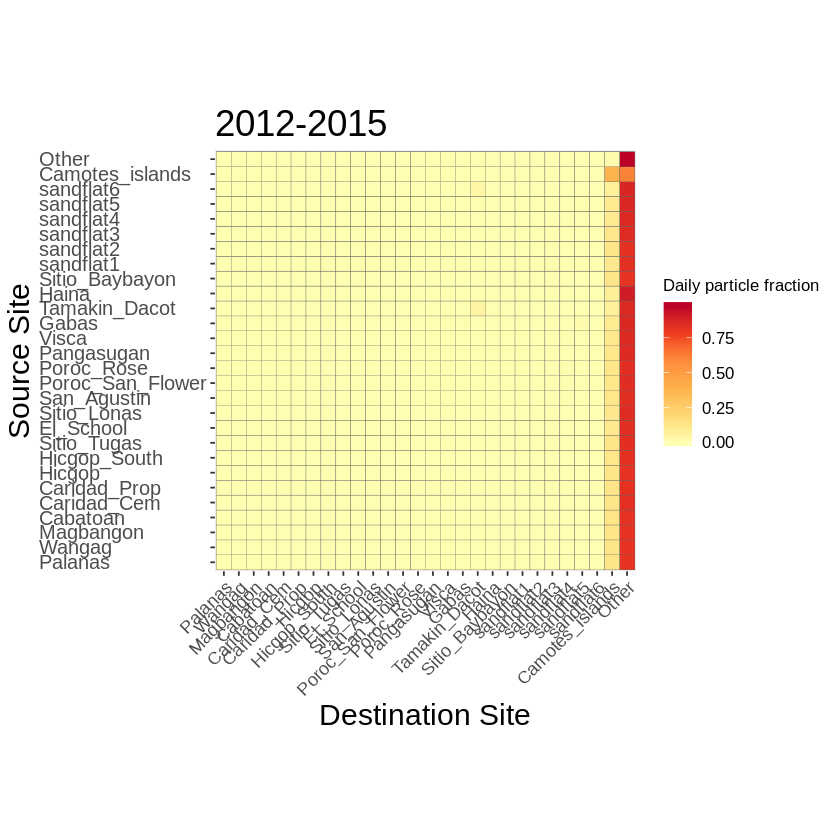

In [152]:
conn_avg <- ggplot(avg, aes(source, destination)) +
geom_tile(aes(fill = avg), color = "grey40") +
   geom_tile(aes(fill = avg), color = "grey40") +
   #scale_fill_gradient(low = "white", high = "steelblue", name="Immigration Fraction") +
   scale_fill_distiller(palette ="YlOrRd", name="Daily particle fraction", direction=1, na.value="whitesmoke")+ 
   ylab("Source Site") +
   xlab("Destination Site") +
   theme(legend.title = element_text(size = 20),
   legend.text = element_text(size = 20),
   plot.title = element_text(size=22),
   axis.title.y=element_text(size=18),
   axis.title.x=element_text(size=18),
   axis.text.x = element_text(size=11, angle = 45, hjust = 1),
   axis.text.y = element_text(size=12, hjust = 0)) +
   coord_fixed(ratio = 1) +
   theme(axis.text.x=element_text(angle=45,hjust=1)) +
   ggtitle("2012-2015") +
   theme(plot.title = element_text(hjust = 0))+
   theme(legend.text=element_text(size=10))+
   theme(legend.title=element_text(size=10))+ 
   theme(panel.border = element_blank(), panel.grid.major = element_blank(),
   panel.grid.minor = element_blank())

conn_avg

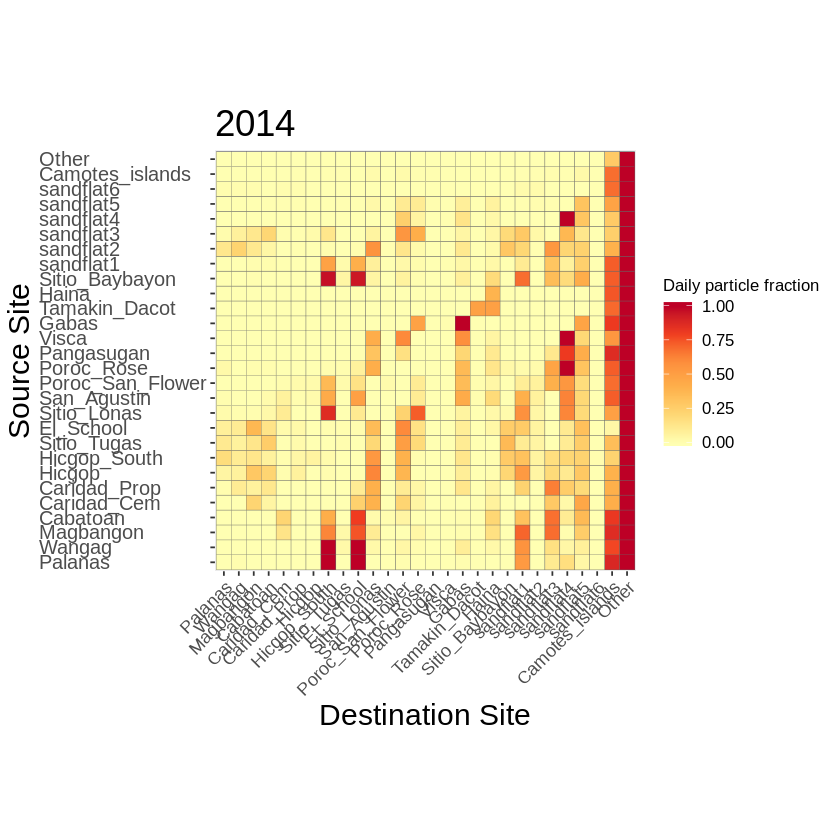

In [153]:

spring12_max <- ggplot(spring12, aes(source, destination)) +
geom_tile(aes(fill = max), color = "grey40") +
   geom_tile(aes(fill = max), color = "grey40") +
   #scale_fill_gradient(low = "white", high = "steelblue", name="Immigration Fraction") +
   scale_fill_distiller(palette ="YlOrRd", name="Daily particle fraction", direction=1, na.value="whitesmoke")+ 
   ylab("Source Site") +
   xlab("Destination Site") +
   theme(legend.title = element_text(size = 20),
   legend.text = element_text(size = 20),
   plot.title = element_text(size=22),
   axis.title.y=element_text(size=18),
   axis.title.x=element_text(size=18),
   axis.text.x = element_text(size=11, angle = 45, hjust = 1),
   axis.text.y = element_text(size=12, hjust = 0)) +
   coord_fixed(ratio = 1) +
   theme(axis.text.x=element_text(angle=45,hjust=1)) +
   ggtitle("2014") +
   theme(plot.title = element_text(hjust = 0))+
   theme(legend.text=element_text(size=10))+
   theme(legend.title=element_text(size=10))+ 
   theme(panel.border = element_blank(), panel.grid.major = element_blank(),
   panel.grid.minor = element_blank())

spring12_max